In [2]:
import numpy as np
import pandas as pd
import pybrain

In [3]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize']= 16,5

In [4]:
from pybrain import FeedForwardNetwork
from pybrain import LinearLayer,SigmoidLayer
from pybrain import FullConnection
from pybrain.supervised.trainers import BackpropTrainer
from pybrain import datasets

In [5]:
def read_Data():
    """
    Function to read data from a defined file with no parameter
    :return: DataFrame, Time Serie
    """
    rawData = pd.read_csv('resources/Consulta_Banxico.csv', sep=',', encoding='latin1', skiprows=15, skip_blank_lines=True)
    Data = rawData.drop(rawData.index[:2])
    Data = Data.reset_index(drop = True)
    Data.columns = ['Fecha' , 'Tasa de crecimiento Mensual']
    TS = pd.Series(Data['Tasa de crecimiento Mensual'].astype(float))
    TS.index= Data['Fecha']
    return Data,TS

In [6]:
def plot_TS(TS):
    plt.figure()
    TS.plot(style='o-', label = 'Series')
    plt.legend()

In [7]:
def create_DataMatrix_Output(dataFrame,TS, lags):
    """
    Function to create DataMatrix and Output values per validation
    :param dataFrame: data readed in read_data()
    :param TS: Time Serie
    :param lags: number of lags 
    :return: DataMatrix and Output Values apart
    """
    dataMatrix = np.zeros((len(dataFrame)-(lags), lags))
    for x in xrange(len(dataFrame)-(lags)):
        dataMatrix[x] = dataFrame[x: x+lags]
    output = TS[lags:]    
    return dataMatrix,output

In [8]:
def create_DS(dataMatrix,output,lags):
    """
    Function to create DataSet per feed FF Neural Network
    :param dataMatrix: DataMatrix
    :param output: Outputs values
    :param lags: number of lags
    :return: DataSet from pybrains
    """
    DS = datasets.SupervisedDataSet(lags, 1)
    for x in xrange(len(dataMatrix)):
        DS.appendLinked(dataMatrix[x], output[x])
    return DS

In [9]:
def create_DataSets(Data,lags):
    """
    Function to divide Dataset into Training and Validation DataSets
    :rtype: object
    :param lags: number of lags
    :return: Training DS, Validation DS, Validation Ouputs per obtain error metric RMSE
    """
    dataM, output = create_DataMatrix_Output(Data['Tasa de crecimiento Mensual'],TS,lags)
    TrainM = dataM[:(len(dataM)-2*6)]
    TrainO = output[:(len(dataM)-2*6)]
    ValM = dataM[(len(dataM)-2*6):(len(dataM)-6)]
    ValO = output[(len(dataM)-2*6):(len(dataM)-6)]
    TrainDS = create_DS(TrainM,TrainO,lags)
    ValDS = create_DS(ValM,ValO,lags)
    return TrainDS,ValDS,ValO

In [10]:
def add_Layers(ffn,inNeurons,hiddenNeurons):
    """
Function to add layers and connections to Neural network
    :param ffn: neural network
    :param inNeurons: number of neurons of the in layer, same as lags
    :param hiddenNeurons: number of neurons of the hidden layer
    :return: ffn, neural network
    """
    inLayer = LinearLayer(inNeurons)
    hiddenLayer = SigmoidLayer(hiddenNeurons)
    outLayer = LinearLayer(1)
    ffn.addInputModule(inLayer)
    ffn.addModule(hiddenLayer)
    ffn.addOutputModule(outLayer)
    in_to_hidden = FullConnection(inLayer,hiddenLayer)
    hidden_to_out = FullConnection(hiddenLayer,outLayer)
    ffn.addConnection(in_to_hidden)
    ffn.addConnection(hidden_to_out)
    ffn.sortModules()
    return ffn

In [11]:
def buildFFN(inNeurons,hiddenNeurons):
    """
    Function to create Feedforward Neural Network from pybrain
    :param inNeurons: number of neurons of in layer
    :param hiddenNeurons: number of neurons of hidden layer
    :return: 
    Feedforward neural network from pybrain
    """
    ffn = FeedForwardNetwork()
    ffn = add_Layers(ffn,inNeurons,hiddenNeurons)
    ffn.sortModules()
    return ffn

In [12]:
def trainFNN(ffn,TrainDS,LearnRate, MaxEpochs):
    """
    Function to train Feedforward Neural Network with Train Dataset, Learning rate and max epoch defined
    :param ffn: feedforward neural network builded from pybrain
    :param TrainDS: Training dataset from pybrain
    :param LearnRate: learning rate (float)
    :param MaxEpochs: Max number of epochs
    :return: FFNN trained
    """
    trainer = BackpropTrainer(ffn, TrainDS,learningrate = LearnRate)
    trainer.trainEpochs(epochs = MaxEpochs)
   #trainer.trainUntilConvergence(verbose= False,validationProportion= 0.1,continueEpochs= 10)
    return ffn

In [13]:
def get_MSE(predictions, output):
    """
    Function to get MSE from diference between predictions and real value (ouptuts)
    :param predictions: predictions made by ffnn
    :param output: true values from output values
    :return: MSE
    """
    return  np.mean(np.sum((output - predictions)**2))

In [14]:
def ValidationTest(ffn, ValDS,output):
    """
    Function to get predictions and MSE
    :param ffn: FFNN builded and trained
    :param ValDS: Validation DataSet
    :param output: Output Values (true values)
    :return: predictions(list of lists), MSE
    """
    predictions = ffn.activateOnDataset(ValDS)
    predictions = predictions.reshape(1,6)
    mse = get_MSE(predictions[0],output)
    return predictions,mse

In [15]:
def init_EpochVar(iterations):
    """
    Function to initialize Variables used in each Epoch
    :param iterations: number of iterations (predictions) to make
    :return: MSE, SumPredictions, ListPredictions
    """
    MSEsum = 0 
    sumPredictions = np.zeros((1,6))
    predictionsList = np.zeros((iterations,6))
    return MSEsum,sumPredictions,predictionsList

In [16]:
def iteration_Func(ffn,TrainDS ,ValDS,ValOutput,lags,hideNeurons,learnR,maxE,iterations):
    """
    Function to made iterations (number of predictions)
    :param ffn: FFNN builded
    :param TrainDS: Training DataSet
    :param ValDS: Validation DataSet
    :param ValOutput: Validation Ouputs
    :param lags: number of lags
    :param learnR: Learning Rate
    :param maxE: Number of max Epochs
    :param iterations: Number of iterations
    :return: MeanPredictions,PredictionsList,meanMSE
    """
    MSEsum, sumPredictions,PredList = init_EpochVar(iterations)
    for epoch in xrange(iterations):
        ffn= buildFFN(lags,hideNeurons)
        ffn= trainFNN(ffn,TrainDS,learnR,maxE)
        predictions,mse = ValidationTest(ffn, ValDS,ValOutput)
        MSEsum += mse
        sumPredictions += predictions
        PredList[epoch] = predictions
    meanPrediction = sumPredictions/iterations
    MSEsum/=iterations
    meanMSE = get_MSE(meanPrediction[0],ValOutput)
    return meanPrediction,PredList,meanMSE

In [37]:
def iteration_Func2(ffn,TrainDS ,ValDS,ValOutput, currentSetup,iterations):
    """
    Function to made iterations (number of predictions)
    :param ffn: FFNN builded
    :param TrainDS: Training DataSet
    :param ValDS: Validation DataSet
    :param ValOutput: Validation Ouputs
    :param currentSetup: Current setup of FFN
    :param iterations: Number of iterations
    :return: MeanPredictions,PredictionsList,meanMSE
    """
    MSEsum, sumPredictions,PredList = init_EpochVar(iterations)
    for epoch in xrange(iterations):
        ffn= buildFFN(currentSetup[0],currentSetup[1])
        ffn= trainFNN(ffn,TrainDS,currentSetup[2],currentSetup[3])
        predictions,mse = ValidationTest(ffn, ValDS,ValOutput)
        MSEsum += mse
        sumPredictions += predictions
        PredList[epoch] = predictions
    meanPrediction = sumPredictions/iterations
    MSEsum/=iterations
    meanMSE = get_MSE(meanPrediction[0],ValOutput)
    return meanPrediction,PredList,meanMSE

In [28]:
def init_BestVar():
    """
    Function to initialize empty Best variables (FNN, MSE, Mean Predictions and Best list Predictions) 
    :return: FNN, MSE, Mean Predictions and Best list Predictions to be filled      
    """
    bestFFN = []
    bestMSE = 10000000000000000
    bestPredicts = []
    bestPredList = []
    return bestFFN,bestPredicts,bestPredList,bestMSE

In [29]:
def SolutionValidation(Predictions,listPred,mse,bestFFN,bestMSE,bestPredictions,bestPredList,lags,hn,LearnR,maxE):
    """
    Function to create and validate solution (FFNN) and choose the best configuration
    :param Predictions: Mean Prediction values
    :param listPred: List of predictions
    :param mse: MSE of Predictions
    :param bestFFN: best FFNN setup at this moment
    :param bestMSE: MSE from best FFNN setup
    :param bestPredictions: Mean Prediction from best FFNN setup
    :param bestPredList: List of predictions from best FFNN setup
    :param lags: number of lags (and in neurons)
    :param hn: number of neurons of hidden layer
    :param LearnR: Learning rate
    :param maxE: Max number of Epochs
    :return: Best MSE, Best FFNN, best Mean Predictions, Best Predictions list
    """
    if(mse < bestMSE):
        bestFFN = [lags,hn,LearnR,maxE]
        bestMSE = mse
        bestPredictions = Predictions
        bestPredList = listPred
    return bestFFN,bestPredictions,bestMSE,bestPredList

In [30]:
def SolutionValidation2(Predictions,listPred,mse,bestFFN,bestMSE,bestPredictions,bestPredList,currentSetup):
    """
    Function to create and validate solution (FFNN) and choose the best configuration
    :param Predictions: Mean Prediction values
    :param listPred: List of predictions
    :param mse: MSE of Predictions
    :param bestFFN: best FFNN setup at this moment
    :param bestMSE: MSE from best FFNN setup
    :param bestPredictions: Mean Prediction from best FFNN setup
    :param bestPredList: List of predictions from best FFNN setup
    :param currentSetup: current setup of FFNN
    :return:  Best FFNN,Best MSE,, best Mean Predictions, Best Predictions list
    """
    if(mse < bestMSE):
        bestFFN = currentSetup
        bestMSE = mse
        bestPredictions = Predictions
        bestPredList = listPred
    return bestFFN,bestMSE,bestPredictions,bestPredList

In [35]:
def FfnnValidation(ParametersList,iterations):
    """
    Function to search over all combiations of setup to chose best FFNN 
    :param ParametersList: List of list of parameters to be combined 
    :param iterations: Number of iterations(predictions) to make
    :return: bestFFN,Mean,bestPredictionList,ValOutput
    """
    bestRNA,bestPredicts,bestPredList,bestMSE  = init_BestVar()
    for lags in ParametersList[0]:
        Data,TS = read_Data()
        TrainDS,ValDS,ValOutput = create_DataSets(Data,lags)
        for HiddenNeurons in ParametersList[1]:
            for learnR in ParametersList[2]:
                for maxE in ParametersList[3]:
                    currentSetup = [lags,HiddenNeurons,learnR,maxE]
                    Predictions,PredList,MSE = iteration_Func2(ffn,TrainDS,ValDS,ValOutput,currentSetup,iterations)
                    bestFFN, bestMSE,bestPredicts,bestPredList = SolutionValidation2(Predictions,PredList,MSE,bestRNA,bestMSE,bestPredicts,bestPredList,currentSetup)
    return bestFFN, bestMSE, bestPredicts, bestPredList,TS

In [17]:
def plot_Solutions(PredictsList,Mean,TS):
    """
    Function to Plot List of predictions, mean predictions and Original Time Serie
    :param PredictsList: List of predictions make
    :param Mean: Mean prediction
    :param TS: Original Time Serie
    :return: matplotlib fig
    """
    fig = plt.figure()
    TSValPredictions = TS[len(TS)-13:len(TS)-6].copy()
    for x in PredictsList:
        TSPredictions = pd.Series(x.astype(float), index = TS.index[len(TS)-12:len(TS)-6])
        TSValPredictions[1:] = TSPredictions.copy()
        TSValPredictions.plot(style = 'yo-')
    TSValOutputs = TS[len(TS)-13:len(TS)-6].copy()
    TSValOutputs.plot(style= 'ko-')
    TSMean = pd.Series(Mean.astype(float), index = TS.index[len(TS)-12:len(TS)-6])
    TSMeanPred = TS[len(TS)-13:len(TS)-6].copy()
    TSMeanPred[1:] = TSMean
    TSMeanPred.plot(style= 'bo-')
    linePred = mlines.Line2D([],[],color='yellow', marker='o',label = 'Predictions')
    lineMean = mlines.Line2D([],[],color='blue', marker='o',label = 'Mean Prediction')
    lineVal = mlines.Line2D([],[],color='black', marker='o',label = 'True Values')
    plt.legend(handles = [linePred,lineMean,lineVal],loc= 1)
    return fig

In [18]:
def plot_predTS(pred,TS):
    """
Function to create a full TS with predictions
    :param pred: predictions
    :param TS: Time Serie
    """
    fig = plt.figure()
    TS= TS[:-6]
    pred = pd.Series(pred.astype(float), index = TS.index[-6:]) 
    TSpred = TS.copy()
    TSpred[-6:] = pred
    TS.plot(style='ko-')
    TSpred.plot()
    plt.legend()

In [21]:
lags = 12
Data,TS = read_Data()
TrainDS, ValDS, ValO = create_DataSets(Data,lags)
hNeurons = 3
ffn = buildFFN(lags,hNeurons)

In [26]:
learnRate = 0.01
MaxEpoch = 100
fnn = trainFNN(ffn,TrainDS,learnRate,MaxEpoch)

In [27]:
predictions,mse = ValidationTest(ffn,ValDS,ValO)

In [28]:
predictions

array([[ 0.0051846 ,  1.91576188,  2.10341009,  1.25197447,  2.09033808,
         3.2309816 ]])

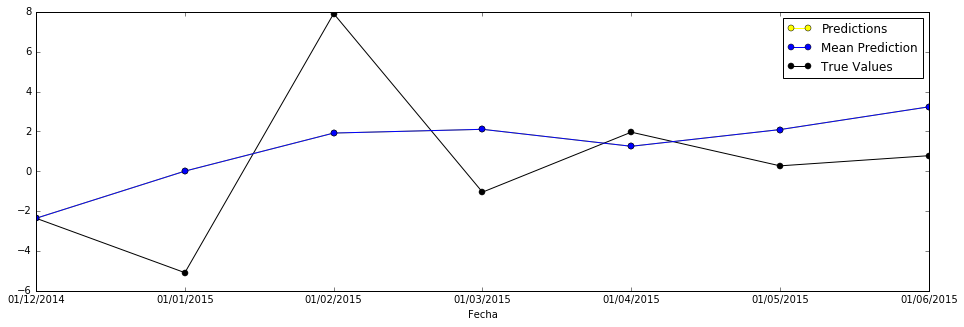

In [29]:
fig = plot_Solutions(predictions,predictions[0],TS)

In [20]:
plot_predTS(predictions[0],TS)

NameError: name 'predictions' is not defined

In [19]:
ParameterList = [12,3,0.01,500]

In [25]:
meanPred,PredList,meanMSE = iteration_Func(ffn,TrainDS,ValDS,ValO,ParameterList[0],ParameterList[1],
                                           ParameterList[2],ParameterList[3],20)

In [26]:
meanMSE

116.64178448896577

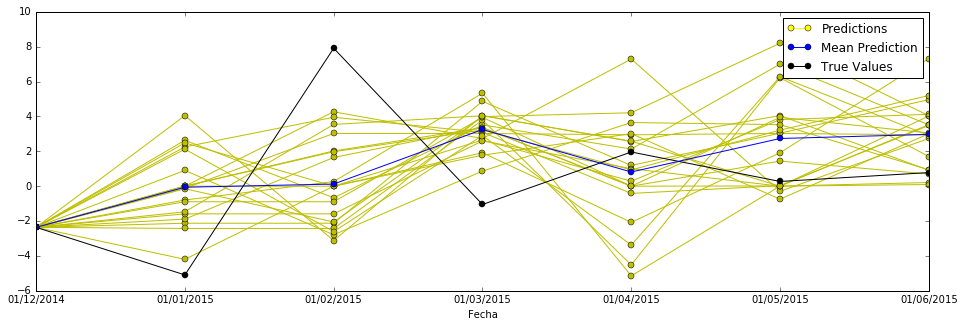

In [27]:
fig = plot_Solutions(PredList,meanPred[0],TS)

In [94]:
fig.savefig('TwoV4.png')

In [45]:
ParameterList2 = [[12],[3],[0.01],[500,1000]]

In [46]:
bestFfn,mse,predictions, predList,TS = FfnnValidation(ParameterList2,1)

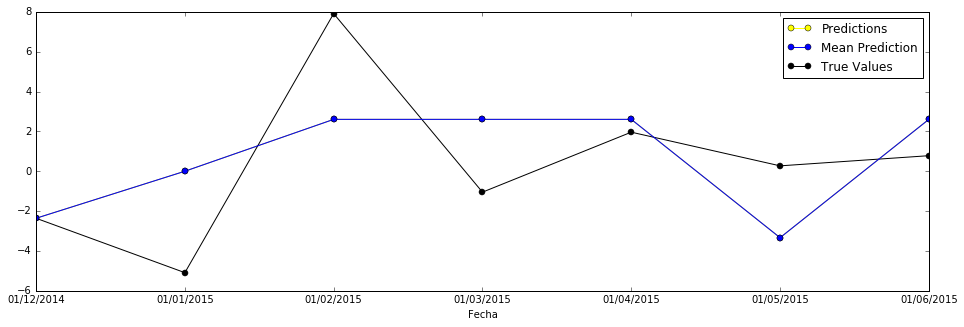

In [47]:
fig = plot_Solutions(predList,predictions[0],TS)

In [52]:
mse

84.157146647980895